In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

## specify # of nodes
Nin: int = 2
extraNin: int = 1
Ninter: int = 1
Nout: int = 2
extraNout: int = 1

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.2  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])
R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]

# length of training dataset
iterations = 3600  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 30

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
# access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
# stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
stay_sample: int = 80

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

alpha_vec [0.2 0.2]
input M mismatches output and input


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [6]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0 1]
extraInput_nodes_arr  [2]
inter_nodes_arr  [3]
output_nodes_arr  [4 5]
extraOutput_nodes_arr  [6]
ground_nodes_arr  [7]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs.Nin, Variabs.Nout, Ninter)
else:
    State = Network_State(Variabs.Nin, Variabs.Nout)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

R_vec_i has wrong size, initializing all ones


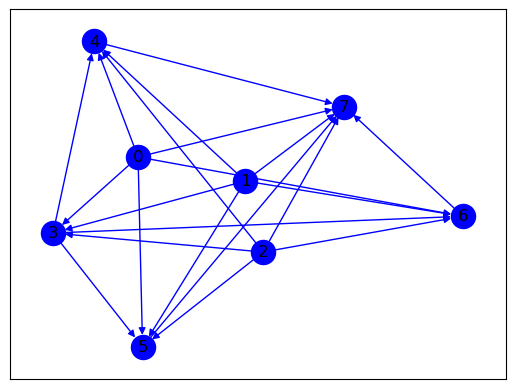

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag:
        k = (i//stay_sample)*2 + i%2
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    State.draw_p_in_and_desired(Variabs, k)
    
    # measure
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        State.update_output_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t):
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776 0.37741292]
output measured= [0.87516802 0.87516802]
i 1
k 1
input_drawn [1.46398788 1.19731697]
desired output= [0.45906158 0.48572867]
output measured= [0.87873273 0.87873273]
loss= [[-0.41967116 -0.39300407]
 [-0.38252026 -0.4977551 ]]
time= 1
input_dual_nxt= [0.99033443 1.00951961]
output_dual_nxt [0.49997351 0.50007468]
inter_dual_nxt= [0.36896265]
i 2
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776 0.37741292]
output measured= [0.87095686 0.87088687]
i 3
k 1
input_drawn [1.46398788 1.19731697]
desired output= [0.45906158 0.48572867]
output measured= [0.88380928 0.88373732]
loss= [[-0.4247477  -0.39800865]
 [-0.3783091  -0.49347395]]
time= 2
input_dual_nxt= [0.98332452 1.01642366]
output_dual_nxt [0.49985414 0.50032004]
inter_dual_nxt= [0.36883531]
i 4
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776 0.37741292]
output measured= [0.45694527 0.45548732]
i 5
k 1
input_drawn

loss= [[ 0.11656641 -0.0084842 ]
 [ 0.05069489  0.05111463]]
time= 68
input_dual_nxt= [1.16774247 0.59520669]
output_dual_nxt [0.13918938 0.07368111]
inter_dual_nxt= [1.1619167]
i 136
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034  0.10920822]
output measured= [-0.04457968  0.08050333]
i 137
k 3
input_drawn [0.11616722 1.73235229]
desired output= [0.36389554 0.20227704]
output measured= [-0.05475317  0.26639595]
loss= [[ 0.41864871 -0.06411892]
 [ 0.15378308  0.0287049 ]]
time= 69
input_dual_nxt= [1.17448204 0.54633432]
output_dual_nxt [0.13865045 0.07023006]
inter_dual_nxt= [1.17133142]
i 138
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034  0.10920822]
output measured= [0.0006023  0.07142783]
i 139
k 3
input_drawn [0.11616722 1.73235229]
desired output= [0.36389554 0.20227704]
output measured= [0.07658803 0.25412916]
loss= [[ 0.28730751 -0.05185213]
 [ 0.1086011   0.03778039]]
time= 70
input_dual_nxt= [1.17797142 0.52103086]
output_dual_nxt [0.14

output measured= [0.80725572 0.79717906]
loss= [[-0.67934642 -0.66958567]
 [-1.91956583 -1.79151784]]
time= 151
input_dual_nxt= [9.79031102 2.64026758]
output_dual_nxt [-109.14187336  -74.8664122 ]
inter_dual_nxt= [-206.74791098]
i 302
k 6
input_drawn [1.66488528 0.42467822]
desired output= [0.33466844 0.45868914]
output measured= [2.17104833 1.83652874]
i 303
k 7
input_drawn [0.36364993 0.36680902]
desired output= [0.12790929 0.12759339]
output measured= [0.78152145 0.64395813]
loss= [[-0.65361216 -0.51636474]
 [-1.83637989 -1.37783959]]
time= 152
input_dual_nxt= [10.32231917  2.66392732]
output_dual_nxt [-109.47057088  -75.07188612]
inter_dual_nxt= [-206.15030437]
i 304
k 6
input_drawn [1.66488528 0.42467822]
desired output= [0.33466844 0.45868914]
output measured= [2.42787265 2.51409864]
i 305
k 7
input_drawn [0.36364993 0.36680902]
desired output= [0.12790929 0.12759339]
output measured= [0.87032344 0.89423906]
loss= [[-0.74241414 -0.76664568]
 [-2.09320422 -2.05540949]]
time= 153


output measured= [1.35408594 1.91402436]
loss= [[-1.11989781 -1.69467966]
 [-1.21399238 -1.69505608]]
time= 233
input_dual_nxt= [17.07691294  4.42415091]
output_dual_nxt [-121.18200738  -87.74413838]
inter_dual_nxt= [-199.89684352]
i 466
k 10
input_drawn [1.22370579 0.27898772]
desired output= [0.23935341 0.33382522]
output measured= [16.67755661 12.05166674]
i 467
k 11
input_drawn [0.5842893  0.73272369]
desired output= [0.23418813 0.21934469]
output measured= [15.32074569 11.06254625]
loss= [[-15.08655756 -10.84320155]
 [-16.4382032  -11.71784152]]
time= 234
input_dual_nxt= [17.36161768  4.22212174]
output_dual_nxt [-121.54879289  -87.91716324]
inter_dual_nxt= [-199.91981169]
i 468
k 10
input_drawn [1.22370579 0.27898772]
desired output= [0.23935341 0.33382522]
output measured= [-2.59827766 -1.43847237]
i 469
k 11
input_drawn [0.5842893  0.73272369]
desired output= [0.23418813 0.21934469]
output measured= [-2.41151472 -1.34810752]
loss= [[2.64570285 1.56745221]
 [2.83763107 1.7722975

output measured= [1.14605499 1.07743925]
i 619
k 15
input_drawn [1.2150897  0.34104825]
desired output= [0.25047311 0.33787725]
output measured= [1.41364651 1.32808223]
loss= [[-1.16317341 -0.99020498]
 [-0.94975045 -0.77194189]]
time= 310
input_dual_nxt= [23.31936798 11.24020912]
output_dual_nxt [-135.30835132 -113.56863529]
inter_dual_nxt= [-152.79714058]
i 620
k 14
input_drawn [1.18482914 0.09290083]
desired output= [0.19630454 0.30549737]
output measured= [1.36322613 1.55470583]
i 621
k 15
input_drawn [1.2150897  0.34104825]
desired output= [0.25047311 0.33787725]
output measured= [1.67953767 1.91557842]
loss= [[-1.42906456 -1.57770117]
 [-1.1669216  -1.24920846]]
time= 311
input_dual_nxt= [23.32294258 11.26952206]
output_dual_nxt [-135.32493509 -113.59234409]
inter_dual_nxt= [-152.75345447]
i 622
k 14
input_drawn [1.18482914 0.09290083]
desired output= [0.19630454 0.30549737]
output measured= [ 0.30029319 -0.12401013]
i 623
k 15
input_drawn [1.2150897  0.34104825]
desired output= 

output measured= [0.77124737 0.70038496]
i 785
k 19
input_drawn [1.36846605 0.88030499]
desired output= [0.38133091 0.43014701]
output measured= [2.25226854 2.06111973]
loss= [[-1.87093763 -1.63097272]
 [-0.6407944  -0.52854365]]
time= 393
input_dual_nxt= [70.81716807 15.59876606]
output_dual_nxt [-195.53930789 -146.95781098]
inter_dual_nxt= [-74.23707238]
i 786
k 18
input_drawn [0.60922754 0.19534423]
desired output= [0.13045298 0.17184131]
output measured= [0.73963944 0.96975506]
i 787
k 19
input_drawn [1.36846605 0.88030499]
desired output= [0.38133091 0.43014701]
output measured= [2.17864958 2.84194112]
loss= [[-1.79731868 -2.41179411]
 [-0.60918647 -0.79791375]]
time= 394
input_dual_nxt= [71.24264725 15.98261979]
output_dual_nxt [-195.88125475 -147.56210784]
inter_dual_nxt= [-73.53286827]
i 788
k 18
input_drawn [0.60922754 0.19534423]
desired output= [0.13045298 0.17184131]
output measured= [0.79319976 0.95441833]
i 789
k 19
input_drawn [1.36846605 0.88030499]
desired output= [0.3

output measured= [0.49127903 0.50265815]
i 955
k 23
input_drawn [0.62342215 1.04013604]
desired output= [0.30154053 0.25986914]
output measured= [0.41517443 0.42659856]
loss= [[-0.1136339  -0.16672942]
 [-0.14863613 -0.2407637 ]]
time= 478
input_dual_nxt= [ 223.7155388  -680.51292659]
output_dual_nxt [-903451.69894949 -928884.44019587]
inter_dual_nxt= [3779525.82898743]
i 956
k 22
input_drawn [0.51755996 1.32504457]
desired output= [0.34264291 0.26189445]
output measured= [1.55915922 1.55508932]
i 957
k 23
input_drawn [0.62342215 1.04013604]
desired output= [0.30154053 0.25986914]
output measured= [1.42639279 1.4229593 ]
loss= [[-1.12485226 -1.16309016]
 [-1.21651631 -1.29319487]]
time= 479
input_dual_nxt= [ 223.71084342 -680.50028983]
output_dual_nxt [-903451.70138347 -928884.44363402]
inter_dual_nxt= [3779525.83134647]
i 958
k 22
input_drawn [0.51755996 1.32504457]
desired output= [0.34264291 0.26189445]
output measured= [0.61212877 0.58290316]
i 959
k 23
input_drawn [0.62342215 1.04

i 1108
k 26
input_drawn [1.87899788 1.7896547 ]
desired output= [0.63978062 0.64871494]
output measured= [1.34057628 1.34898164]
i 1109
k 27
input_drawn [1.19579996 1.84374847]
desired output= [0.54811969 0.48332484]
output measured= [1.18411562 1.18824456]
loss= [[-0.63599594 -0.70491972]
 [-0.70079566 -0.7002667 ]]
time= 555
input_dual_nxt= [ 299.42516514 -679.66309112]
output_dual_nxt [-916473.87956379 -940904.50078531]
inter_dual_nxt= [3706726.42879408]
i 1110
k 26
input_drawn [1.87899788 1.7896547 ]
desired output= [0.63978062 0.64871494]
output measured= [2.91085812 2.90143662]
i 1111
k 27
input_drawn [1.19579996 1.84374847]
desired output= [0.54811969 0.48332484]
output measured= [2.44612624 2.43863262]
loss= [[-1.89800655 -1.95530779]
 [-2.2710775  -2.25272168]]
time= 556
input_dual_nxt= [ 299.51677991 -679.67034493]
output_dual_nxt [-916473.91423939 -940904.52831418]
inter_dual_nxt= [3706726.45388603]
i 1112
k 26
input_drawn [1.87899788 1.7896547 ]
desired output= [0.63978062 

output measured= [1.13510341 1.13505492]
loss= [[-0.74378082 -0.6493355 ]
 [-0.42250474 -0.39840407]]
time= 619
input_dual_nxt= [ 300.85660328 -679.18856147]
output_dual_nxt [-916487.04407891 -940916.99790208]
inter_dual_nxt= [3706686.2710955]
i 1238
k 30
input_drawn [0.77735458 0.54269806]
desired output= [0.2251428  0.24860845]
output measured= [0.78742627 0.78453793]
i 1239
k 31
input_drawn [1.65747502 0.71350665]
desired output= [0.39132258 0.48571942]
output measured= [1.3973628 1.3927013]
loss= [[-1.00604021 -0.90698188]
 [-0.56228347 -0.53592948]]
time= 620
input_dual_nxt= [ 301.00002931 -679.16072619]
output_dual_nxt [-916487.0982116  -940917.04303418]
inter_dual_nxt= [3706686.301163]
i 1240
k 30
input_drawn [0.77735458 0.54269806]
desired output= [0.2251428  0.24860845]
output measured= [0.55540494 0.55681611]
i 1241
k 31
input_drawn [1.65747502 0.71350665]
desired output= [0.39132258 0.48571942]
output measured= [0.95820989 0.96228506]
loss= [[-0.56688731 -0.47656564]
 [-0.33

i 1376
k 34
input_drawn [0.14910129 1.97377387]
desired output= [0.41711997 0.23465271]
output measured= [0.72606129 0.72952695]
i 1377
k 35
input_drawn [1.54448954 0.39743136]
desired output= [0.3111597  0.42586552]
output measured= [0.11611297 0.1395933 ]
loss= [[ 0.19504673  0.28627222]
 [-0.30894132 -0.49487425]]
time= 689
input_dual_nxt= [ 358.423923   -744.94888251]
output_dual_nxt [-918668.7000774  -942982.65955274]
inter_dual_nxt= [3702701.46690456]
i 1378
k 34
input_drawn [0.14910129 1.97377387]
desired output= [0.41711997 0.23465271]
output measured= [7.44482457 7.55044122]
i 1379
k 35
input_drawn [1.54448954 0.39743136]
desired output= [0.3111597  0.42586552]
output measured= [3.86941054 3.90852332]
loss= [[-3.55825084 -3.4826578 ]
 [-7.0277046  -7.31578851]]
time= 690
input_dual_nxt= [ 356.38593489 -742.64660765]
output_dual_nxt [-918671.18102412 -942985.4515422 ]
inter_dual_nxt= [3702733.02888751]
i 1380
k 34
input_drawn [0.14910129 1.97377387]
desired output= [0.41711997 

i 1526
k 38
input_drawn [1.54254069 0.1480893 ]
desired output= [0.26099896 0.4004441 ]
output measured= [0.67381195 0.67764182]
i 1527
k 39
input_drawn [0.71693146 0.23173812]
desired output= [0.15388734 0.20240668]
output measured= [0.39833644 0.39969818]
loss= [[-0.2444491  -0.19729151]
 [-0.41281298 -0.27719772]]
time= 764
input_dual_nxt= [ 365.55940612 -753.13478555]
output_dual_nxt [-918810.3500323  -943123.19590457]
inter_dual_nxt= [3703473.6174419]
i 1528
k 38
input_drawn [1.54254069 0.1480893 ]
desired output= [0.26099896 0.4004441 ]
output measured= [1.07977757 1.07577185]
i 1529
k 39
input_drawn [0.71693146 0.23173812]
desired output= [0.15388734 0.20240668]
output measured= [0.6146948  0.61229972]
loss= [[-0.46080746 -0.40989305]
 [-0.8187786  -0.67532774]]
time= 765
input_dual_nxt= [ 365.66234404 -753.14521499]
output_dual_nxt [-918810.38332954 -943123.22050889]
inter_dual_nxt= [3703473.65595052]
i 1530
k 38
input_drawn [1.54254069 0.1480893 ]
desired output= [0.26099896 0

output measured= [1.74282737 1.73670246]
i 1671
k 41
input_drawn [0.66179605 0.1271167 ]
desired output= [0.12469275 0.17816068]
output measured= [0.44877247 0.44759356]
loss= [[-0.32407973 -0.26943287]
 [-1.23457709 -1.18049112]]
time= 836
input_dual_nxt= [ 383.68388781 -742.77536558]
output_dual_nxt [-918861.15531826 -943170.89776906]
inter_dual_nxt= [3703334.38066991]
i 1672
k 40
input_drawn [1.72620685 1.24659625]
desired output= [0.50825028 0.55621134]
output measured= [1.32648229 1.32782546]
i 1673
k 41
input_drawn [0.66179605 0.1271167 ]
desired output= [0.12469275 0.17816068]
output measured= [0.32461084 0.32603339]
loss= [[-0.19991809 -0.1478727 ]
 [-0.81823201 -0.77161412]]
time= 837
input_dual_nxt= [ 383.94829924 -742.49727447]
output_dual_nxt [-918861.27921247 -943171.0227409 ]
inter_dual_nxt= [3703334.22716518]
i 1674
k 40
input_drawn [1.72620685 1.24659625]
desired output= [0.50825028 0.55621134]
output measured= [1.94761443 1.93964638]
i 1675
k 41
input_drawn [0.66179605

output measured= [0.53588918 0.47065856]
loss= [[-0.21471299 -0.26821248]
 [-1.29992358 -1.2511341 ]]
time= 917
input_dual_nxt= [ 401.32527521 -738.46261172]
output_dual_nxt [-918947.69798302 -943251.67375629]
inter_dual_nxt= [3702950.71850326]
i 1834
k 44
input_drawn [1.77442549 0.94442985]
desired output= [0.45504979 0.53804936]
output measured= [0.82309941 0.83485104]
i 1835
k 45
input_drawn [0.23918849 1.42648957]
desired output= [0.32117619 0.20244608]
output measured= [0.69899793 0.69878632]
loss= [[-0.37782174 -0.49634024]
 [-0.36804962 -0.29680169]]
time= 918
input_dual_nxt= [ 401.26100692 -738.44243167]
output_dual_nxt [-918947.69774048 -943251.66832625]
inter_dual_nxt= [3702950.61997252]
i 1836
k 44
input_drawn [1.77442549 0.94442985]
desired output= [0.45504979 0.53804936]
output measured= [2.26775915 2.26160868]
i 1837
k 45
input_drawn [0.23918849 1.42648957]
desired output= [0.32117619 0.20244608]
output measured= [1.50061295 1.49828268]
loss= [[-1.17943676 -1.2958366 ]
 [

i 1990
k 48
input_drawn [1.04546566 0.85508204]
desired output= [0.32783626 0.34687462]
output measured= [4.13570695 4.00233277]
i 1991
k 49
input_drawn [0.05083825 0.21578285]
desired output= [0.05078231 0.03428785]
output measured= [0.80053828 0.77343715]
loss= [[-0.74975597 -0.7391493 ]
 [-3.8078707  -3.65545816]]
time= 996
input_dual_nxt= [ 409.97409095 -733.30639541]
output_dual_nxt [-919125.11330017 -943416.90959299]
inter_dual_nxt= [3702118.00121535]
i 1992
k 48
input_drawn [1.04546566 0.85508204]
desired output= [0.32783626 0.34687462]
output measured= [3.61208498 3.49791301]
i 1993
k 49
input_drawn [0.05083825 0.21578285]
desired output= [0.05078231 0.03428785]
output measured= [0.70748378 0.68377367]
loss= [[-0.65670147 -0.64948582]
 [-3.28424872 -3.15103839]]
time= 997
input_dual_nxt= [ 410.9943996  -732.65058954]
output_dual_nxt [-919126.63969555 -943418.3175365 ]
inter_dual_nxt= [3702109.4282842]
i 1994
k 48
input_drawn [1.04546566 0.85508204]
desired output= [0.32783626 0

i 2158
k 52
input_drawn [1.81513295 0.49858446]
desired output= [0.37198683 0.50364168]
output measured= [1.80595581 1.79991559]
i 2159
k 53
input_drawn [0.82076585 1.51110228]
desired output= [0.42533533 0.35630169]
output measured= [1.74361382 1.73703077]
loss= [[-1.31827849 -1.38072908]
 [-1.43396897 -1.29627391]]
time= 1080
input_dual_nxt= [ 406.12293499 -728.0485746 ]
output_dual_nxt [-919161.86434047 -943451.87824161]
inter_dual_nxt= [3702038.28267205]
i 2160
k 54
input_drawn [0.45759633 0.15395982]
desired output= [0.09943141 0.12979506]
output measured= [0.44097477 0.42939957]
i 2161
k 55
input_drawn [0.57950291 0.32244257]
desired output= [0.15141395 0.17711998]
output measured= [0.72664831 0.70548847]
loss= [[-0.57523436 -0.52836849]
 [-0.34154336 -0.29960451]]
time= 1081
input_dual_nxt= [ 406.13421025 -728.03299146]
output_dual_nxt [-919161.87769233 -943451.89087345]
inter_dual_nxt= [3702038.20827173]
i 2162
k 54
input_drawn [0.45759633 0.15395982]
desired output= [0.0994314

output measured= [0.96114587 0.97219427]
loss= [[-0.42254051 -0.48120027]
 [-0.59851079 -0.58350204]]
time= 1156
input_dual_nxt= [ 413.10432148 -729.10171556]
output_dual_nxt [-919254.6665475  -943539.19551846]
inter_dual_nxt= [3701810.77181987]
i 2312
k 56
input_drawn [1.8593953  1.61624076]
desired output= [0.60215745 0.6264729 ]
output measured= [2.9858798  2.97915487]
i 2313
k 57
input_drawn [1.26680751 1.74292118]
desired output= [0.53860536 0.490994  ]
output measured= [2.541114   2.53468957]
loss= [[-2.00250864 -2.04369557]
 [-2.38372236 -2.35268197]]
time= 1157
input_dual_nxt= [ 413.18612232 -729.11920253]
output_dual_nxt [-919254.70045766 -943539.22298521]
inter_dual_nxt= [3701810.81026875]
i 2314
k 56
input_drawn [1.8593953  1.61624076]
desired output= [0.60215745 0.6264729 ]
output measured= [9.20224789 9.31634947]
i 2315
k 57
input_drawn [1.26680751 1.74292118]
desired output= [0.53860536 0.490994  ]
output measured= [7.26909794 7.35423665]
loss= [[-6.73049258 -6.86324266]


i 2472
k 60
input_drawn [1.61488031 1.7921826 ]
desired output= [0.60066857 0.58293834]
output measured= [2.20547875 2.19638712]
i 2473
k 61
input_drawn [0.63600695 0.22010385]
desired output= [0.13942181 0.18101212]
output measured= [0.56762119 0.56506913]
loss= [[-0.42819938 -0.384057  ]
 [-1.60481018 -1.61344879]]
time= 1237
input_dual_nxt= [ 438.46616813 -687.38403277]
output_dual_nxt [-919832.83192033 -944078.98137086]
inter_dual_nxt= [3699186.12090285]
i 2474
k 60
input_drawn [1.61488031 1.7921826 ]
desired output= [0.60066857 0.58293834]
output measured= [0.93580319 0.95220914]
i 2475
k 61
input_drawn [0.63600695 0.22010385]
desired output= [0.13942181 0.18101212]
output measured= [0.29970942 0.30140935]
loss= [[-0.16028761 -0.12039722]
 [-0.33513462 -0.3692708 ]]
time= 1238
input_dual_nxt= [ 438.54912189 -687.25080834]
output_dual_nxt [-919832.85416415 -944079.01376424]
inter_dual_nxt= [3699186.1828137]
i 2476
k 60
input_drawn [1.61488031 1.7921826 ]
desired output= [0.60066857

i 2628
k 64
input_drawn [0.01390426 1.02149461]
desired output= [0.20638456 0.10562553]
output measured= [0.3785963  0.38194267]
i 2629
k 65
input_drawn [0.83482201 0.44421562]
desired output= [0.21406643 0.25312706]
output measured= [0.58775957 0.58723822]
loss= [[-0.37369315 -0.33411116]
 [-0.17221174 -0.27631715]]
time= 1315
input_dual_nxt= [ 431.82934659 -690.93855776]
output_dual_nxt [-920301.3568388  -944517.58758482]
inter_dual_nxt= [3697262.75795886]
i 2630
k 64
input_drawn [0.01390426 1.02149461]
desired output= [0.20638456 0.10562553]
output measured= [0.68094803 0.67830973]
i 2631
k 65
input_drawn [0.83482201 0.44421562]
desired output= [0.21406643 0.25312706]
output measured= [0.89018805 0.88645319]
loss= [[-0.67612163 -0.63332612]
 [-0.47456347 -0.57268421]]
time= 1316
input_dual_nxt= [ 431.87239553 -690.96883028]
output_dual_nxt [-920301.36527361 -944517.59010927]
inter_dual_nxt= [3697262.72628272]
i 2632
k 64
input_drawn [0.01390426 1.02149461]
desired output= [0.2063845

i 2790
k 68
input_drawn [1.03758124 1.40603792]
desired output= [0.43684477 0.3999991 ]
output measured= [1.08628384 1.08741769]
i 2791
k 69
input_drawn [0.7272592  1.94356417]
desired output= [0.49780171 0.37617122]
output measured= [1.13263228 1.13599415]
loss= [[-0.63483057 -0.75982294]
 [-0.64943907 -0.68741859]]
time= 1396
input_dual_nxt= [ 434.42277989 -692.42964986]
output_dual_nxt [-920371.37379776 -944582.32786596]
inter_dual_nxt= [3696936.46109137]
i 2792
k 68
input_drawn [1.03758124 1.40603792]
desired output= [0.43684477 0.3999991 ]
output measured= [1.60882173 1.60225253]
i 2793
k 69
input_drawn [0.7272592  1.94356417]
desired output= [0.49780171 0.37617122]
output measured= [1.73469731 1.72790025]
loss= [[-1.2368956  -1.35172904]
 [-1.17197696 -1.20225343]]
time= 1397
input_dual_nxt= [ 434.40947364 -692.40660136]
output_dual_nxt [-920371.37543209 -944582.33162221]
inter_dual_nxt= [3696936.47680375]
i 2794
k 68
input_drawn [1.03758124 1.40603792]
desired output= [0.4368447

i 2944
k 72
input_drawn [0.56968099 0.07377389]
desired output= [0.10020693 0.14979764]
output measured= [-0.09463614 -0.08315315]
i 2945
k 73
input_drawn [1.21912867 1.00535805]
desired output= [0.38394091 0.40531797]
output measured= [-1.35365138 -1.27708683]
loss= [[1.73759229 1.6824048 ]
 [0.19484307 0.23295078]]
time= 1473
input_dual_nxt= [ 427.5234838 -716.947891 ]
output_dual_nxt [-921804.1966086 -945914.2990537]
inter_dual_nxt= [3689686.69621321]
i 2946
k 72
input_drawn [0.56968099 0.07377389]
desired output= [0.10020693 0.14979764]
output measured= [0.28184192 0.28293459]
i 2947
k 73
input_drawn [1.21912867 1.00535805]
desired output= [0.38394091 0.40531797]
output measured= [1.51304285 1.44571848]
loss= [[-1.12910194 -1.04040051]
 [-0.181635   -0.13313695]]
time= 1474
input_dual_nxt= [ 427.76439389 -716.60232349]
output_dual_nxt [-921804.42991303 -945914.51004399]
inter_dual_nxt= [3689685.16449762]
i 2948
k 72
input_drawn [0.56968099 0.07377389]
desired output= [0.10020693 0.

i 3104
k 76
input_drawn [0.28978974 0.97890552]
desired output= [0.23924957 0.17033799]
output measured= [-1.29327764 -1.2308874 ]
i 3105
k 77
input_drawn [1.97130091 0.48411054]
desired output= [0.39251724 0.54123628]
output measured= [-0.60711954 -0.55445181]
loss= [[0.99963678 1.09568809]
 [1.5325272  1.40122539]]
time= 1553
input_dual_nxt= [ 455.01836058 -717.97641258]
output_dual_nxt [-921834.34960981 -945942.7438997 ]
inter_dual_nxt= [3689889.2009619]
i 3106
k 76
input_drawn [0.28978974 0.97890552]
desired output= [0.23924957 0.17033799]
output measured= [1.14934066 1.06968434]
i 3107
k 77
input_drawn [1.97130091 0.48411054]
desired output= [0.39251724 0.54123628]
output measured= [1.20937011 1.19618381]
loss= [[-0.81685286 -0.65494752]
 [-0.91009109 -0.89934635]]
time= 1554
input_dual_nxt= [ 454.90481249 -717.94300036]
output_dual_nxt [-921834.3484904  -945942.73771643]
inter_dual_nxt= [3689889.57062823]
i 3108
k 76
input_drawn [0.28978974 0.97890552]
desired output= [0.23924957

output measured= [1.10889128 1.10458212]
i 3259
k 81
input_drawn [1.26705942 1.07154937]
desired output= [0.40436879 0.42391979]
output measured= [1.26080316 1.25705003]
loss= [[-0.85643437 -0.83313024]
 [-0.74563401 -0.79422938]]
time= 1630
input_dual_nxt= [ 456.29075615 -715.45159974]
output_dual_nxt [-922250.49909358 -946329.45321009]
inter_dual_nxt= [3687702.42596928]
i 3260
k 80
input_drawn [0.73556627 1.26461166]
desired output= [0.36325727 0.31035273]
output measured= [1.14603121 1.14136051]
i 3261
k 81
input_drawn [1.26705942 1.07154937]
desired output= [0.40436879 0.42391979]
output measured= [1.30992567 1.30555632]
loss= [[-0.90555688 -0.88163653]
 [-0.78277394 -0.83100778]]
time= 1631
input_dual_nxt= [ 456.30918957 -715.45829559]
output_dual_nxt [-922250.50311826 -946329.45487269]
inter_dual_nxt= [3687702.43953045]
i 3262
k 80
input_drawn [0.73556627 1.26461166]
desired output= [0.36325727 0.31035273]
output measured= [1.06498725 1.06158015]
i 3263
k 81
input_drawn [1.267059

i 3414
k 84
input_drawn [0.08155028 1.18178589]
desired output= [0.24858972 0.13856616]
output measured= [1.87962388 1.8902213 ]
i 3415
k 85
input_drawn [1.35512872 0.03317566]
desired output= [0.20990444 0.34209975]
output measured= [1.44859539 1.44966855]
loss= [[-1.23869095 -1.1075688 ]
 [-1.63103416 -1.75165514]]
time= 1708
input_dual_nxt= [ 455.05731406 -714.51286588]
output_dual_nxt [-922270.4416928 -946349.7472923]
inter_dual_nxt= [3687855.43758955]
i 3416
k 84
input_drawn [0.08155028 1.18178589]
desired output= [0.24858972 0.13856616]
output measured= [0.83005677 0.82612233]
i 3417
k 85
input_drawn [1.35512872 0.03317566]
desired output= [0.20990444 0.34209975]
output measured= [0.83408406 0.83159751]
loss= [[-0.62417962 -0.48949777]
 [-0.58146705 -0.68755617]]
time= 1709
input_dual_nxt= [ 455.01774503 -714.47717951]
output_dual_nxt [-922270.44172721 -946349.74707542]
inter_dual_nxt= [3687855.39552628]
i 3418
k 84
input_drawn [0.08155028 1.18178589]
desired output= [0.24858972 

output measured= [0.27726206 0.29766167]
i 3587
k 89
input_drawn [1.87345998 0.27504189]
desired output= [0.33602737 0.49586918]
output measured= [0.08741655 0.11467141]
loss= [[0.24861082 0.38119778]
 [0.0847134  0.12515426]]
time= 1794
input_dual_nxt= [ 480.50333211 -737.27822973]
output_dual_nxt [-922775.27380333 -946872.90292639]
inter_dual_nxt= [3694124.64333057]
i 3588
k 88
input_drawn [1.38187548 0.77347069]
desired output= [0.36197546 0.42281594]
output measured= [4.33650283 4.37909035]
i 3589
k 89
input_drawn [1.87345998 0.27504189]
desired output= [0.33602737 0.49586918]
output measured= [3.49728931 3.52411022]
loss= [[-3.16126194 -3.02824104]
 [-3.97452737 -3.95627442]]
time= 1795
input_dual_nxt= [ 480.33213301 -737.10464703]
output_dual_nxt [-922775.410304   -946873.06161641]
inter_dual_nxt= [3694126.47082843]
i 3590
k 88
input_drawn [1.38187548 0.77347069]
desired output= [0.36197546 0.42281594]
output measured= [1.19776307 1.19446497]
i 3591
k 89
input_drawn [1.87345998 0

In [12]:
BigClass.Strctr.inter_nodes_arr

array([3])

## Plots

### importants + network

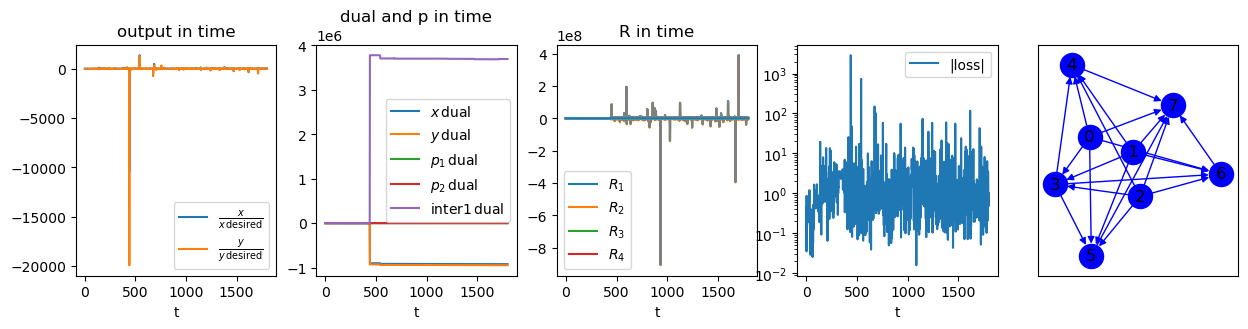

In [13]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

### accuracy

In [14]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(Variabs, State)
else:
    pass

## Save sizes to file

In [15]:
# R_propto_deltap = State.R_in_t
# deltaR_propto_deltap = State.R_in_t
# deltaR_propto_Q = State.R_in_t
# deltaR_propto_Power = State.R_in_t

# loss_R_propto_deltap = State.loss_in_t
# loss_deltaR_propto_deltap = State.loss_in_t
# loss_propto_Q = State.loss_in_t
# loss_propto_Power = State.loss_in_t

In [16]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)

In [17]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [18]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

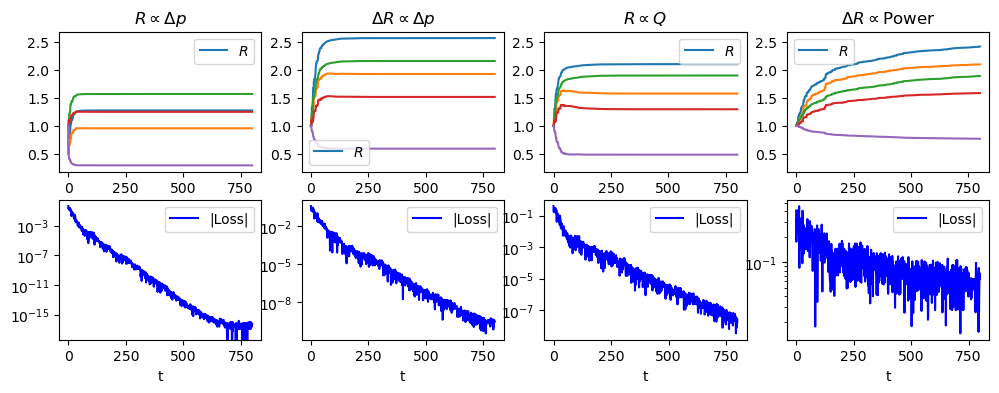

In [19]:
plot_functions.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [20]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [21]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [22]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [23]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

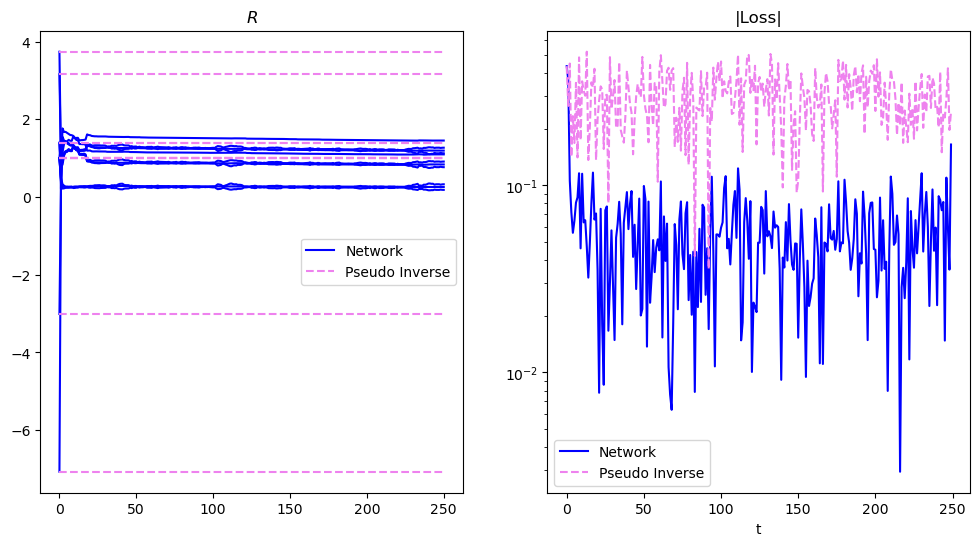

In [24]:
plot_functions.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

## Statistics

### Error

In [25]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 3.7591072666023337


### Accuracy

In [26]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    print('net prediction', np.sum((State.targets_mat - State.output)**2, axis=1))
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [0.74908024 1.90142861]
desired output= [0.49264776 0.37741292]
output measured= [0.51051702 0.52823923]


AttributeError: 'Network_State' object has no attribute 'targets_mat'

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)